# **Brain Abnormality Classification**



**Full name:Abolfazl Malekahmadi**

**Student Number:*401205167*

In this exercise we are going to train a CNN-based model for a multi-class classification task, brain abnormality classification. The dataset we are going to use is a small imbalanced one that contains MRIs of both normal and abnormal brains.
We will learn how to use and refine models that have been already trained on some other rich datasets to deal with situations in which we don't have access to good datasets or powerful hardware.
This exercise has been broken into some smaller sections and each section has its score. What you are supposed to do is shown in `"======== TODO ========"` format. Any part which is showed by `...` should be completed. with There may be some **Questions** in the notes below. It is not necessary to answer these questions, but they will help you to do the next sections.

# Imports

First of all we need to import required libraries.

In [84]:
from __future__ import print_function
from __future__ import division
import imgaug
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import shutil
import os
import random
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


## 1.1) Download Dataset

The following pieces of code will download dataset to your colab storage and remove corrupted or useless files.

In [85]:
#!wget --content-disposition https://figshare.com/ndownloader/files/28399209
!mkdir dataset
!tar xvf NINS_Dataset.tar --directory dataset/

Streaming output truncated to the last 5000 lines.
./Brain Infection with abscess/58211497.jpg
./Brain Infection with abscess/58211513.jpg
./Brain Infection with abscess/58211529.jpg
./Brain Infection with abscess/58211545.jpg
./Brain Infection with abscess/58211561.jpg
./Brain Infection with abscess/58211577.jpg
./Brain Infection with abscess/58211593.jpg
./Brain Infection with abscess/58211609.jpg
./Brain Infection with abscess/97887252.jpg
./Brain Infection with abscess/97887268.jpg
./Brain Infection with abscess/97887284.jpg
./Brain Infection with abscess/97887300.jpg
./Brain Infection with abscess/97887316.jpg
./Brain Infection with abscess/97887332.jpg
./Brain Infection with abscess/97887348.jpg
./Brain Infection with abscess/97887364.jpg
./Brain Infection with abscess/97887380.jpg
./Brain Infection with abscess/97887396.jpg
./Brain Infection with abscess/97887412.jpg
./Brain Infection with abscess/97887428.jpg
./Brain Infection with abscess/97887444.jpg
./Brain Infection with ab

In [86]:
# Set the directory containing the images
data_dir = 'dataset/'

classes = os.listdir(data_dir)
shutil.rmtree(os.path.join(data_dir, 'models'))
classes = os.listdir(data_dir)

for c in classes:
    images = os.listdir(os.path.join(data_dir, c))
    for image in images:
      if image[-4:] != '.jpg':
        corrupted_img = os.path.join(data_dir, c, image)
        try:
          os.remove(corrupted_img)
        except:
          shutil.rmtree(corrupted_img)

## 1.2) Splitting Dataset: 5

The data should be spilitted into three groups: train, validation, and test. The groups' size are your choice and they should be reasonable, but it is recommended to use 0.8, 0.1, and 0.1 for train, validation, and test, respectively.

In [87]:
import os

# Set up directories and data splits
root_dir = 'dataset'
classes = os.listdir(root_dir)

############## To Do ##############
train_split = 0.8
val_split = 0.1
test_split = 0.1
###################################

# Create a dictionary with images and labels
data_dict = {}
for idx, class_name in enumerate(classes):
    class_dir = os.path.join(root_dir, class_name)
    data_dict[class_name] = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

############## To Do ##############
# Create train, validation and test splits
# Also print the number of samples in each class
train_images = []
val_images = []
test_images = []
for cls_name, images in data_dict.items():
    num_samples = len(images)
    num_train = int(train_split * num_samples)
    num_val = int(val_split * num_samples)
    num_test = num_samples - num_train - num_val

    train_images.extend(images[:num_train])
    val_images.extend(images[num_train:num_train + num_val])
    test_images.extend(images[num_train + num_val:])

    print(cls_name + ":", num_samples)
    print(f" - Train samples: {len(train_images)}")
    print(f" - Validation samples: {len(val_images)}")
    print(f" - Test samples: {len(test_images)}")
###################################


Brain Atrophy: 264
 - Train samples: 211
 - Validation samples: 26
 - Test samples: 27
Brain Infection: 38
 - Train samples: 241
 - Validation samples: 29
 - Test samples: 32
Brain Infection with abscess: 76
 - Train samples: 301
 - Validation samples: 36
 - Test samples: 41
Brain Tumor: 76
 - Train samples: 361
 - Validation samples: 43
 - Test samples: 50
Brain Tumor (Ependymoma): 36
 - Train samples: 389
 - Validation samples: 46
 - Test samples: 55
Brain Tumor (Hemangioblastoma  Pleomorphic xanthroastrocytoma  metastasis): 74
 - Train samples: 448
 - Validation samples: 53
 - Test samples: 63
Brain tumor (Astrocytoma Ganglioglioma): 38
 - Train samples: 478
 - Validation samples: 56
 - Test samples: 68
Brain tumor (Dermoid cyst craniopharyngioma): 38
 - Train samples: 508
 - Validation samples: 59
 - Test samples: 73
Brain tumor - Recurrenceremnant of previous lesion: 114
 - Train samples: 599
 - Validation samples: 70
 - Test samples: 85
Brain tumor operated with ventricular hemor

**Question:** How many classes are there in your dataset?The dataset contains a total of 37 classes.


**Question:** Did you notice the imbalance between classes?
Yes, I noticed that there is an imbalance between the classes in the dataset. Some classes have a relatively small number of samples, while others have a larger number of samples. This class imbalance can potentially affect the performance of a machine learning model trained on this dataset, as it may become biased towards the majority classes and struggle to properly classify the minority classes

We put samples of each group in a seperate folder.

In [88]:
!mkdir train val test

n_img = 0
for image in train_images:
  n_img += 1
  os.makedirs(os.path.join('train', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('train', *image.split('/')[1:]))

for image in val_images:
  os.makedirs(os.path.join('val', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('val', *image.split('/')[1:]))

for image in test_images:
  os.makedirs(os.path.join('test', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('test', *image.split('/')[1:]))

## 1.3) Calculate Weights of Calsses: 5

In [89]:
wgts = []

for c in classes:
    print(c)

    # Count the number of samples in the current class in the training set
    num_samples = sum([1 for img in train_images if c in img])

    # Calculate the weight as the inverse frequency of the class in the training set
    weight = len(train_images) / num_samples

    wgts.append(weight)

    print('Size of Class: ' + str(num_samples))
    print('Weight of Class: ' + str(weight))
    print()

wgts = torch.Tensor(wgts)




Brain Atrophy
Size of Class: 211
Weight of Class: 19.938388625592417

Brain Infection
Size of Class: 90
Weight of Class: 46.74444444444445

Brain Infection with abscess
Size of Class: 60
Weight of Class: 70.11666666666666

Brain Tumor
Size of Class: 147
Weight of Class: 28.61904761904762

Brain Tumor (Ependymoma)
Size of Class: 28
Weight of Class: 150.25

Brain Tumor (Hemangioblastoma  Pleomorphic xanthroastrocytoma  metastasis)
Size of Class: 59
Weight of Class: 71.30508474576271

Brain tumor (Astrocytoma Ganglioglioma)
Size of Class: 30
Weight of Class: 140.23333333333332

Brain tumor (Dermoid cyst craniopharyngioma)
Size of Class: 30
Weight of Class: 140.23333333333332

Brain tumor - Recurrenceremnant of previous lesion
Size of Class: 91
Weight of Class: 46.23076923076923

Brain tumor operated with ventricular hemorrhage
Size of Class: 60
Weight of Class: 70.11666666666666

Cerebral Hemorrhage
Size of Class: 28
Weight of Class: 150.25

Cerebral abscess
Size of Class: 28
Weight of Cl

As you saw there exists an imbalance between classes. The dataset contains a class with more than a thousand samples and classes with fewer than 50 samples.

Here we want to calculate coefficients (weights) that can compensate this gap. So you are supposed to calculate these coefficients for each class such that if you multiply a class size by its corresponding coefficient the result will be equal for all the other classes. The minimum value of a coefficient should be 1.

In [90]:
import cv2
import numpy as np
import glob

# Step 1: Load the images
folder_paths = glob.glob('/content/drive/MyDrive/HW4/dataset/*/')  # Get paths of all folders
image_files = []
for folder_path in folder_paths:
    image_files.extend(glob.glob(folder_path + '*.jpg'))

images = [cv2.imread(file) for file in image_files]

images_np = [np.array(image) for image in images]

# Step 3: Calculate the mean and standard deviation
# Flatten each array and compute the mean and std dev
means = [np.mean(image) for image in images_np]
stddevs = [np.std(image) for image in images_np]

# Compute the overall mean and std dev
overall_mean = np.mean(means)
overall_stddev = np.mean(stddevs)

print('Mean: ', overall_mean)
print('Standard Deviation: ', overall_stddev)


Mean:  54.63066539870165
Standard Deviation:  58.83895571936826


In [91]:
print('Mean: ', overall_mean/224)
print('Standard Deviation: ', overall_stddev/224)

Mean:  0.24388689910134667
Standard Deviation:  0.26267390946146546


In [92]:
# Compute the mean and std dev for each color channel
means = [np.mean(image, axis=(0, 1)) for image in images_np]
stddevs = [np.std(image, axis=(0, 1)) for image in images_np]

# Compute the overall mean and std dev for each color channel
overall_mean = np.mean(means, axis=0)/255
overall_stddev = np.mean(stddevs, axis=0)/255
overall_mean


array([0.2142379, 0.2142379, 0.2142379])

In [93]:
overall_stddev

array([0.230741, 0.230741, 0.230741])

## 1.4) Create DataLoaders: 5

We read and put the data of each group in its corresponding list.

In [94]:
train_images = []
train_aug_images = []
val_images = []
test_images = []

for c in classes:
    class_dir = os.path.join('train', c)
    train_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('val', c)
    val_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('test', c)
    test_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

Define required transforms and create Dataloaders.

**Question:** What is the approperiate input size of models like ResNet, VGG, etc.? Becarefull about the size of your images as well.

Input Image Size: Use 224x224 pixels for ResNet and VGG, or the specific standard size used in the pretrained models you're working with.


Batch Size: Choose a batch size like 32, 64, or 128 based on your hardware and dataset size.


Input Range: Normalize the pixel values of your images to the range [0, 1] by dividing the original pixel values by 255.

**Notice:** Select a suitable batch size.

**Notice:** Becarefull about the range of input values. They should be in [0, 1).

In [95]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_list, classes=None, transform=None):
        self.image_list = image_list
        self.transform = transform
        self.label_encoder = {c: i for (i, c) in enumerate(classes)}

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image = Image.open(self.image_list[index])

        if self.transform is not None:
            image = self.transform(image)

        label = self.image_list[index].split('/')[-2]
        label = self.label_encoder[label]

        return image, label


############## To Do ##############

# Define the transformations to be applied on the train and validation sets
transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the appropriate input size for models like ResNet, VGG, etc.
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.32, 0.32, 0.32], std=[0.25, 0.25, 0.25]),  # Normalize image tensors
])

# Create datasets using defined CustomDataset class
train_dataset = CustomDataset(train_images, classes, transform=transforms)
val_dataset = CustomDataset(val_images, classes, transform=transforms)
test_dataset = CustomDataset(test_images, classes, transform=transforms)
# Create dataloaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

###################################

## 1.2) Data Visualization

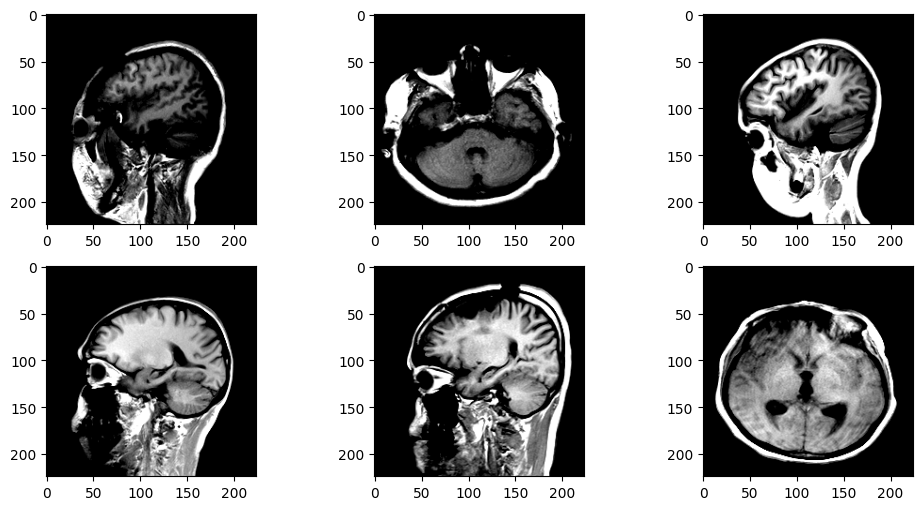

In [96]:
fig, axis = plt.subplots(2, 3, figsize=(12, 6))
for i, batch in enumerate(train_loader):
  axis[0, 0].imshow(np.array(batch[0][0]).transpose(1, 2, 0))
  axis[0, 1].imshow(np.array(batch[0][1]).transpose(1, 2, 0))
  axis[0, 2].imshow(np.array(batch[0][2]).transpose(1, 2, 0))
  axis[1, 0].imshow(np.array(batch[0][-3]).transpose(1, 2, 0),)
  axis[1, 1].imshow(np.array(batch[0][-2]).transpose(1, 2, 0),)
  axis[1, 2].imshow(np.array(batch[0][-1]).transpose(1, 2, 0),)
  break

In [97]:
data_loaders = {'train': train_loader, 'val': val_loader}
num_cls = len(classes)

# 2) Model Initialization and Structure Modification


## 2.1) ResNet50: 10

Load ResNet50 model with its pretrained weights. (Suggestion: IMAGENET1K_V2)

In [98]:
############## To Do ##############
resnet_model = models.resnet50(pretrained='IMAGENET1K_V2')
###################################
print(resnet_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Question:** Which part of this model is mainly used for classification? What kind of layer(s) are in this part? How many outputs does this model have? Why?


In the ResNet50 model, the main part used for classification is the fully connected layer, often referred to as the "classifier" or "fc" layer. This layer is responsible for taking the features extracted from the convolutional layers and mapping them to the predicted classes.  The ResNet50 model has a single fully connected layer at the end, which is a linear layer (nn.Linear) in PyTorch. The specific layer can be accessed using resnet_model.fc.  The number of outputs of this model is determined by the number of classes in your specific classification task. By default, the ResNet50 model is pretrained on the ImageNet dataset, which consists of 1000 classes. However, since you are working with your own dataset, you will need to modify the last fully connected layer to match the number of classes in your dataset. This ensures that the model predicts the correct number of output classes for your classification task.

we have 37 classes

Modify the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [99]:
############## To Do ##############
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, num_cls)
###################################
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [100]:
# Specify the device (Suggestion: GPU is by far better than CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

## 2.2) VGG16: 10

Load VGG16 model with its pretrained parameters. (Suggestion: IMAGENET1K_V1)

In [101]:
############## To Do ##############
vgg_model = models.vgg16(pretrained='IMAGENET1K_V1')

###################################
print(vgg_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Question:** Which part of this model is mainly used for classification? What kind of layer(s) are in this part? How many outputs does this model have? Why

Modify the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [102]:
############## To Do ##############
num_ftrs = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = nn.Linear(num_ftrs, num_cls)

###################################
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [103]:
# Specify the device (Suggestion: GPU is by far better than CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg_model = vgg_model.to(device)

# 3) Train Function: 15

Define your loss function for multi class classification. Don't forget to add class weights to it.

In [104]:
wgts = wgts.to(device)

############## To Do ##############
criterion = nn.CrossEntropyLoss(weight=wgts)
###################################

Here you should define your main train function.

**Note1:** Since you are going to change the data during the training procedure, your train function have to get dataloaders as input.

**Note2:** Also you don't know how many epochs you should train.
  So save the best weights according to validation loss at the end of each epoch,
  and after the end of training, load the best model.

**Note3:** Save loss and accuracy of train and validation in each epoch to plot them later.

**Note4:** The following code is an template that can help you, but any other functions that you define with the desired properties is acceptable.


In [105]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=10):
    since = time.time()

    acc_hist = {'train': [], 'val': []}
    loss_hist = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            training = (phase == 'train')
            model.train(training)  # Set model to training or evaluation mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(training):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if training:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'val' and scheduler is not None:
                scheduler.step(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            acc_hist[phase].append(epoch_acc)
            loss_hist[phase].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)

    return model, acc_hist, loss_hist


# 4) Feature Extraction


In this section with just update parameters of the recently modified layer(s).

### 4.1) ResNet50

### 4.1.1) Freezing: 5

You should freeze all the parameters of the model except those of the new layer(s) you have just added.

**Help:** You can use `requires_grad` feature in Pytorch.

In [106]:
############## To Do ##############
for name, param in resnet_model.named_parameters():
    if name.startswith('fc'):
        param.requires_grad = True
    else:
        param.requires_grad = False
###################################

### 4.1.2) Training: 5

Set optimizer such that just the parameters of the new layer(s) be updateded.

**Becareful:** Learning rate is a critical hyper parameter in this training task.

Scheduler is optional.

In [107]:
############## To Do ##############
# Get the parameters of the new layer(s)
new_layer_params = list(resnet_model.fc.parameters())

# Create the optimizer with the new layer parameters
resnet_optimizer = torch.optim.SGD(new_layer_params, lr=0.001)
###################################

lr_scheduler = None

In [108]:
############## To Do ##############

resnet_fe, resnet_acc_fe, resnet_loss_fe = train_model(resnet_model, data_loaders, criterion, resnet_optimizer, lr_scheduler, num_epochs=10)
###################################

Epoch 0/9
----------
train Loss: 3.6120 Acc: 0.0359
val Loss: 3.4844 Acc: 0.0614

Epoch 1/9
----------
train Loss: 3.5335 Acc: 0.0718
val Loss: 3.4596 Acc: 0.0752

Epoch 2/9
----------
train Loss: 3.4614 Acc: 0.0749
val Loss: 3.4792 Acc: 0.0455

Epoch 3/9
----------
train Loss: 3.3974 Acc: 0.1046
val Loss: 3.4340 Acc: 0.0653

Epoch 4/9
----------
train Loss: 3.3291 Acc: 0.1120
val Loss: 3.4178 Acc: 0.0376

Epoch 5/9
----------
train Loss: 3.2624 Acc: 0.1436
val Loss: 3.3630 Acc: 0.0713

Epoch 6/9
----------
train Loss: 3.1959 Acc: 0.1600
val Loss: 3.3791 Acc: 0.0495

Epoch 7/9
----------
train Loss: 3.1488 Acc: 0.1773
val Loss: 3.3696 Acc: 0.0455

Epoch 8/9
----------
train Loss: 3.0904 Acc: 0.1773
val Loss: 3.3074 Acc: 0.0554

Epoch 9/9
----------
train Loss: 3.0352 Acc: 0.1994
val Loss: 3.2843 Acc: 0.0535

Training complete in 6m 44s
Best val Acc: 0.0752


### 4.2) VGG16

### 4.2.1) Freezing: 5

You should freeze all the parameters of the model except those of the new layer(s) you have just added.

**Help:** You can use `requires_grad` feature in Pytorch.

In [109]:
# Freeze all parameters of VGG16
for param in vgg_model.features.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the classification layers
for param in vgg_model.classifier.parameters():
    param.requires_grad = True


### 4.2.2) Training: 5

Set optimizer such that just the parameters of the new layer(s) be updateded.

**Becareful:** Learning rate is a critical hyper parameter in this training task.

Scheduler is optional.

In [110]:
import torch
############## To Do ##############
vgg_optimizer = torch.optim.SGD(vgg_model.classifier.parameters(), lr=0.01)  # Replace 'new_layer' with the actual name of the new layer(s) in the VGG model
###################################

lr_scheduler = None

In [111]:
############## To Do ##############
# Assuming you have already created train_loader, val_loader, and test_loader



vgg_fe, vgg_acc_fe, vgg_loss_fe = train_model(vgg_model, data_loaders, criterion, vgg_optimizer, lr_scheduler, num_epochs=10)
###################################

Epoch 0/9
----------
train Loss: 3.2131 Acc: 0.0673
val Loss: 3.2061 Acc: 0.0495

Epoch 1/9
----------
train Loss: 2.1345 Acc: 0.1842
val Loss: 2.9574 Acc: 0.0554

Epoch 2/9
----------
train Loss: 1.3728 Acc: 0.2867
val Loss: 3.6955 Acc: 0.0376

Epoch 3/9
----------
train Loss: 1.0103 Acc: 0.3708
val Loss: 2.7704 Acc: 0.1545

Epoch 4/9
----------
train Loss: 0.6837 Acc: 0.4538
val Loss: 2.9944 Acc: 0.1327

Epoch 5/9
----------
train Loss: 0.4695 Acc: 0.5256
val Loss: 2.7792 Acc: 0.1465

Epoch 6/9
----------
train Loss: 0.3652 Acc: 0.5824
val Loss: 2.8174 Acc: 0.2040

Epoch 7/9
----------
train Loss: 0.2803 Acc: 0.6482
val Loss: 2.8081 Acc: 0.1980

Epoch 8/9
----------
train Loss: 0.2108 Acc: 0.6870
val Loss: 2.5500 Acc: 0.2376

Epoch 9/9
----------
train Loss: 0.2111 Acc: 0.7110
val Loss: 2.6142 Acc: 0.2337

Training complete in 8m 32s
Best val Acc: 0.2376


# 5) Fine-Tuning


In this section the whole parameters of the model are going to be updated.

## 5.1) ResNet50

### 5.1.1) Unfreezing

Unfreeze all the parameters.

In [112]:
############## To Do ##############
for param in resnet_model.parameters():
    param.requires_grad = True
###################################

### 5.1.2) Train the Model: 5

Set optimizer such that all the parameters of the model be updateded.

**Becareful:** Since we are fine-tuning the model, we expect slight changes in the parameters, so learning rate should be very small in this section. You can also define different learning rates for newly modified layer(s) and the rest of the model.

Scheduler is optional.

In [113]:
############## To Do ##############
resnet_optimizer = torch.optim.SGD(resnet_model.parameters(), lr=0.001)

lr_scheduler = None
resnet_ft, resnet_acc_ft, resnet_loss_ft = train_model(resnet_model, data_loaders, criterion, resnet_optimizer, lr_scheduler, num_epochs=10)

###################################

Epoch 0/9
----------
train Loss: 3.4220 Acc: 0.1017
val Loss: 3.3949 Acc: 0.0653

Epoch 1/9
----------
train Loss: 3.1522 Acc: 0.1640
val Loss: 3.3410 Acc: 0.0535

Epoch 2/9
----------
train Loss: 2.7800 Acc: 0.2047
val Loss: 3.2825 Acc: 0.0594

Epoch 3/9
----------
train Loss: 2.4141 Acc: 0.2503
val Loss: 3.1548 Acc: 0.0614

Epoch 4/9
----------
train Loss: 2.0609 Acc: 0.2883
val Loss: 3.0788 Acc: 0.0733

Epoch 5/9
----------
train Loss: 1.7400 Acc: 0.3157
val Loss: 3.0386 Acc: 0.0713

Epoch 6/9
----------
train Loss: 1.4675 Acc: 0.3561
val Loss: 3.0955 Acc: 0.0693

Epoch 7/9
----------
train Loss: 1.2220 Acc: 0.3841
val Loss: 2.9208 Acc: 0.0832

Epoch 8/9
----------
train Loss: 1.0180 Acc: 0.4395
val Loss: 2.8676 Acc: 0.0970

Epoch 9/9
----------
train Loss: 0.8622 Acc: 0.4723
val Loss: 2.7236 Acc: 0.1168

Training complete in 11m 36s
Best val Acc: 0.1168


## 5.2) VGG16

### 5.2.1) Unfreezing

Unfreeze all the parameters.

In [114]:
for param in vgg_model.parameters():
    param.requires_grad = True
vgg_optimizer = torch.optim.SGD(vgg_model.parameters(), lr=0.001)
lr_scheduler = None


### 5.2.2) Train the Model: 5

Set optimizer such that all the parameters of the model be updateded.

**Becareful:** Since we are fine-tuning the model, we expect slight changes in the parameters, so learning rate should be very small in this section. You can also define different learning rates for newly modified layer(s) and the rest of the model.

Scheduler is optional.

In [115]:
vgg_ft, vgg_acc_ft, vgg_loss_ft = train_model(vgg_model, data_loaders, criterion, vgg_optimizer, lr_scheduler, num_epochs=10)


Epoch 0/9
----------
train Loss: 0.1532 Acc: 0.7428
val Loss: 2.8767 Acc: 0.2475

Epoch 1/9
----------
train Loss: 0.1478 Acc: 0.7642
val Loss: 2.9558 Acc: 0.2396

Epoch 2/9
----------
train Loss: 0.1084 Acc: 0.7889
val Loss: 3.1052 Acc: 0.2634

Epoch 3/9
----------
train Loss: 0.1132 Acc: 0.8044
val Loss: 3.0035 Acc: 0.2713

Epoch 4/9
----------
train Loss: 0.1042 Acc: 0.8117
val Loss: 3.1456 Acc: 0.2772

Epoch 5/9
----------
train Loss: 0.0834 Acc: 0.8400
val Loss: 3.1143 Acc: 0.3149

Epoch 6/9
----------
train Loss: 0.0842 Acc: 0.8410
val Loss: 3.2561 Acc: 0.2990

Epoch 7/9
----------
train Loss: 0.0732 Acc: 0.8422
val Loss: 3.2788 Acc: 0.3109

Epoch 8/9
----------
train Loss: 0.0783 Acc: 0.8519
val Loss: 3.2057 Acc: 0.2970

Epoch 9/9
----------
train Loss: 0.0650 Acc: 0.8676
val Loss: 3.5188 Acc: 0.2713

Training complete in 15m 13s
Best val Acc: 0.3149


## 6) Plot Learning Curves: 5

Put the results of feature extraction and fine-tuning together and plot 2 figures for each of the models: accuracy and loss against epochs, i.e. 4 figures at all. Plot validation and train in one figure. Plot a vertical line that distinguish between feature extraction and fine-tuning epochs.

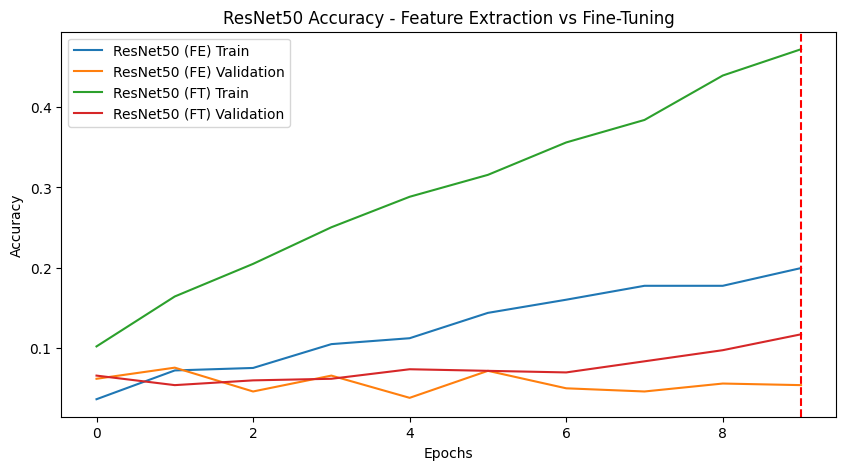

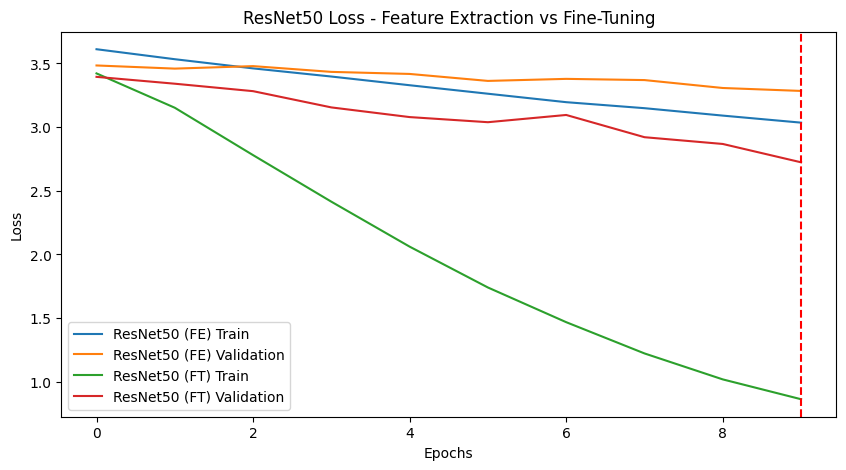

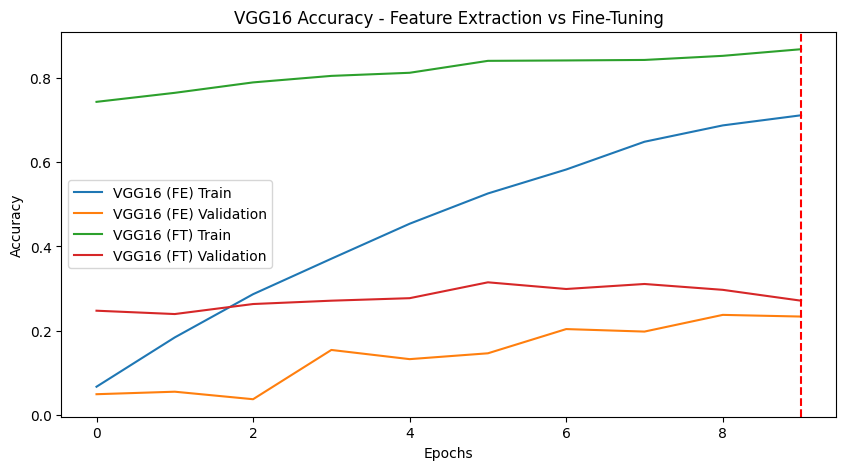

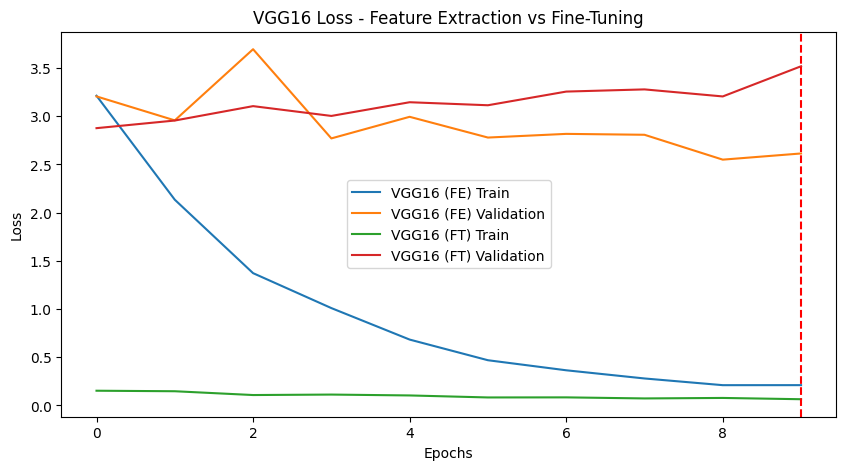

In [135]:
import matplotlib.pyplot as plt
import numpy as np
num_epochs=9
# Convert lists to tensors
resnet_acc_fe_train = torch.tensor(resnet_acc_fe['train'])
resnet_acc_fe_val = torch.tensor(resnet_acc_fe['val'])
resnet_loss_fe_train = torch.tensor(resnet_loss_fe['train'])
resnet_loss_fe_val = torch.tensor(resnet_loss_fe['val'])
resnet_acc_ft_train = torch.tensor(resnet_acc_ft['train'])
resnet_acc_ft_val = torch.tensor(resnet_acc_ft['val'])
resnet_loss_ft_train = torch.tensor(resnet_loss_ft['train'])
resnet_loss_ft_val = torch.tensor(resnet_loss_ft['val'])

vgg_acc_fe_train = torch.tensor(vgg_acc_fe['train'])
vgg_acc_fe_val = torch.tensor(vgg_acc_fe['val'])
vgg_loss_fe_train = torch.tensor(vgg_loss_fe['train'])
vgg_loss_fe_val = torch.tensor(vgg_loss_fe['val'])
vgg_acc_ft_train = torch.tensor(vgg_acc_ft['train'])
vgg_acc_ft_val = torch.tensor(vgg_acc_ft['val'])
vgg_loss_ft_train = torch.tensor(vgg_loss_ft['train'])
vgg_loss_ft_val = torch.tensor(vgg_loss_ft['val'])

# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(resnet_acc_fe_train, label='ResNet50 (FE) Train')
plt.plot(resnet_acc_fe_val, label='ResNet50 (FE) Validation')
plt.plot(resnet_acc_ft_train, label='ResNet50 (FT) Train')
plt.plot(resnet_acc_ft_val, label='ResNet50 (FT) Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50 Accuracy - Feature Extraction vs Fine-Tuning')
plt.legend()
plt.axvline(x=num_epochs, color='r', linestyle='--')
plt.show()

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(resnet_loss_fe_train, label='ResNet50 (FE) Train')
plt.plot(resnet_loss_fe_val, label='ResNet50 (FE) Validation')
plt.plot(resnet_loss_ft_train, label='ResNet50 (FT) Train')
plt.plot(resnet_loss_ft_val, label='ResNet50 (FT) Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet50 Loss - Feature Extraction vs Fine-Tuning')
plt.legend()
plt.axvline(x=num_epochs, color='r', linestyle='--')
plt.show()

# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(vgg_acc_fe_train, label='VGG16 (FE) Train')
plt.plot(vgg_acc_fe_val, label='VGG16 (FE) Validation')
plt.plot(vgg_acc_ft_train, label='VGG16 (FT) Train')
plt.plot(vgg_acc_ft_val, label='VGG16 (FT) Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG16 Accuracy - Feature Extraction vs Fine-Tuning')
plt.legend()
plt.axvline(x=num_epochs, color='r', linestyle='--')
plt.show()

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(vgg_loss_fe_train, label='VGG16 (FE) Train')
plt.plot(vgg_loss_fe_val, label='VGG16 (FE) Validation')
plt.plot(vgg_loss_ft_train, label='VGG16 (FT) Train')
plt.plot(vgg_loss_ft_val, label='VGG16 (FT) Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG16 Loss - Feature Extraction vs Fine-Tuning')
plt.legend()
plt.axvline(x=num_epochs, color='r', linestyle='--')
plt.show()



In [ ]:
############## To Do ##############
# Your code ...
###################################

## 7) Confusion Matrix: 5

Plot confusion matrix for each of the models. It should be a `num_of_classes * num_of_classes` square.

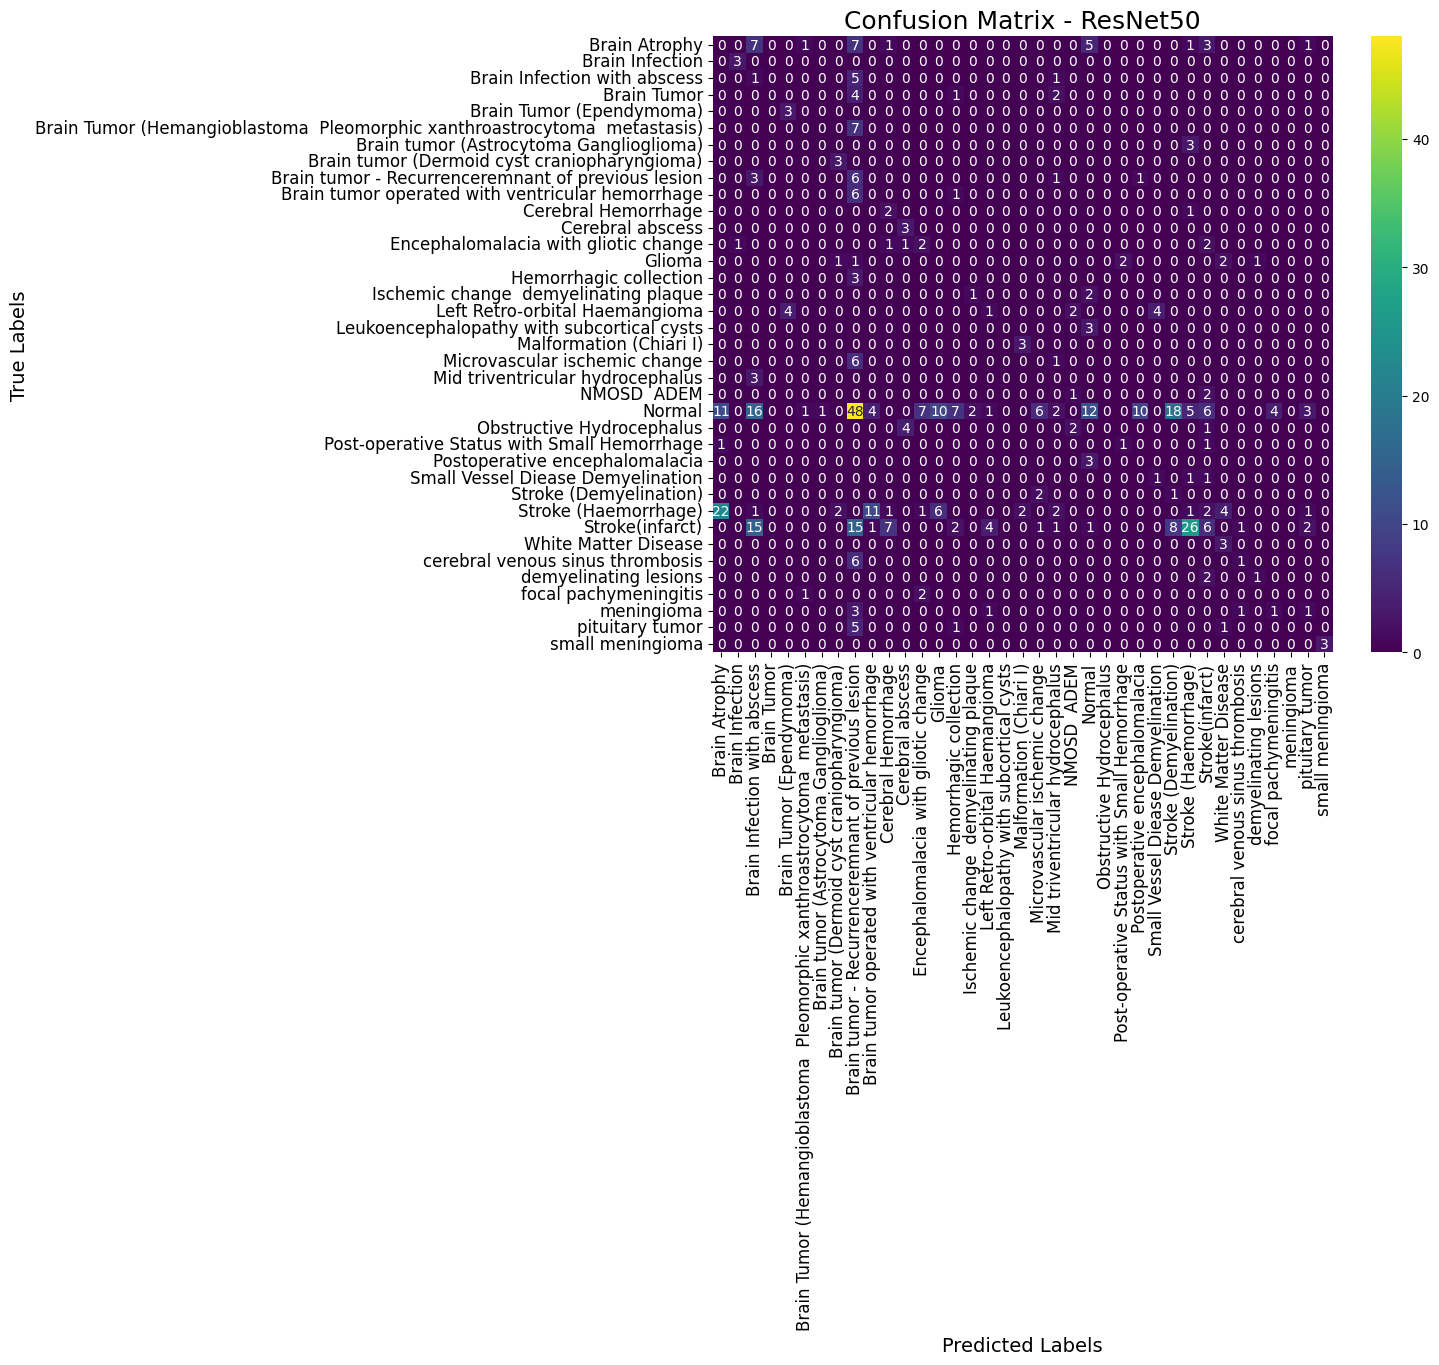

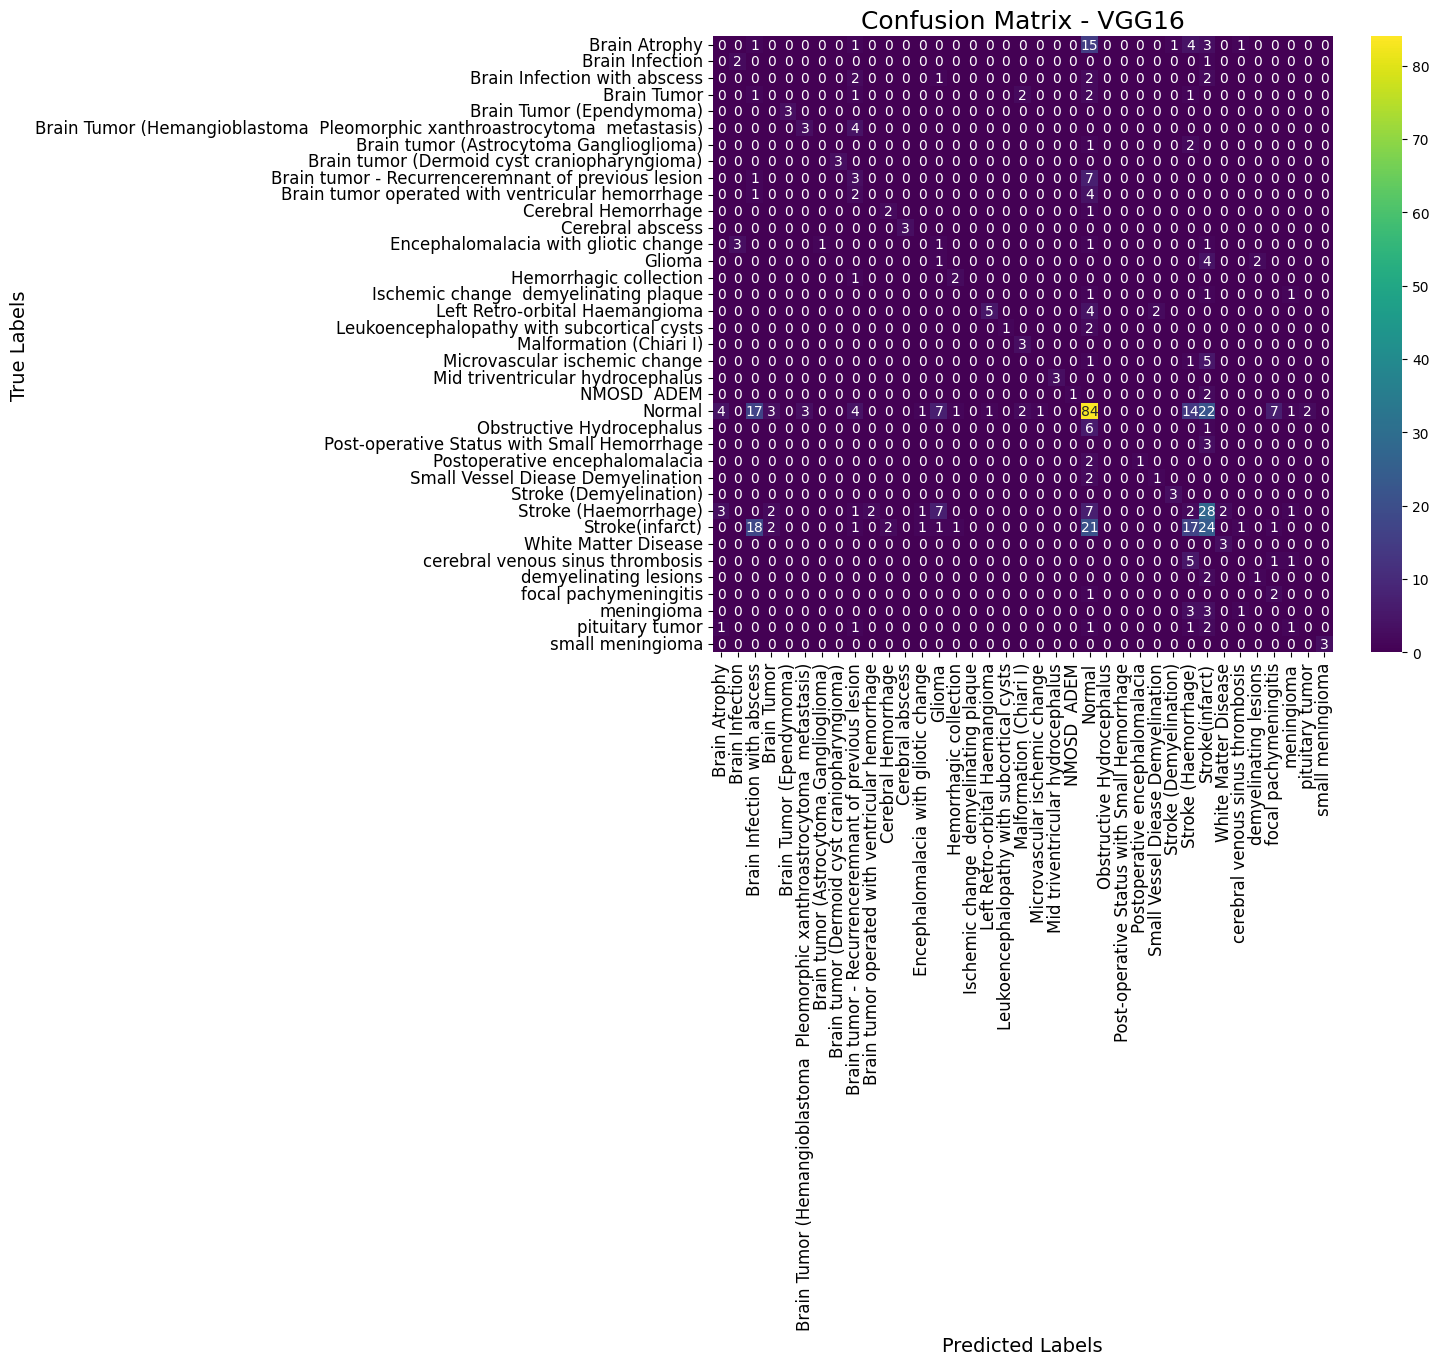

In [134]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def predict_model(model, dataloader):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return torch.tensor(predictions), torch.tensor(true_labels)

def plot_confusion_matrix(cm, title, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="viridis", cbar=True, xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=18)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.tick_params(axis='both', labelsize=12)
    plt.show()

# Get predictions for the validation set
resnet_preds, resnet_labels = predict_model(resnet_model, val_loader)
vgg_preds, vgg_labels = predict_model(vgg_model, val_loader)

# Convert predictions and labels to numpy arrays
resnet_preds = resnet_preds.cpu().numpy()
resnet_labels = resnet_labels.cpu().numpy()
vgg_preds = vgg_preds.cpu().numpy()
vgg_labels = vgg_labels.cpu().numpy()

# Calculate the confusion matrices
resnet_cm = confusion_matrix(resnet_labels, resnet_preds)
vgg_cm = confusion_matrix(vgg_labels, vgg_preds)

# Plot the confusion matrices with enhanced visualization
plot_confusion_matrix(resnet_cm, 'Confusion Matrix - ResNet50',classes)
plot_confusion_matrix(vgg_cm, 'Confusion Matrix - VGG16',classes)


# 9) Evaluate on Test Split: 10

Calculate the accuracy of each model on test data and also plot confusion matrix for both of them.

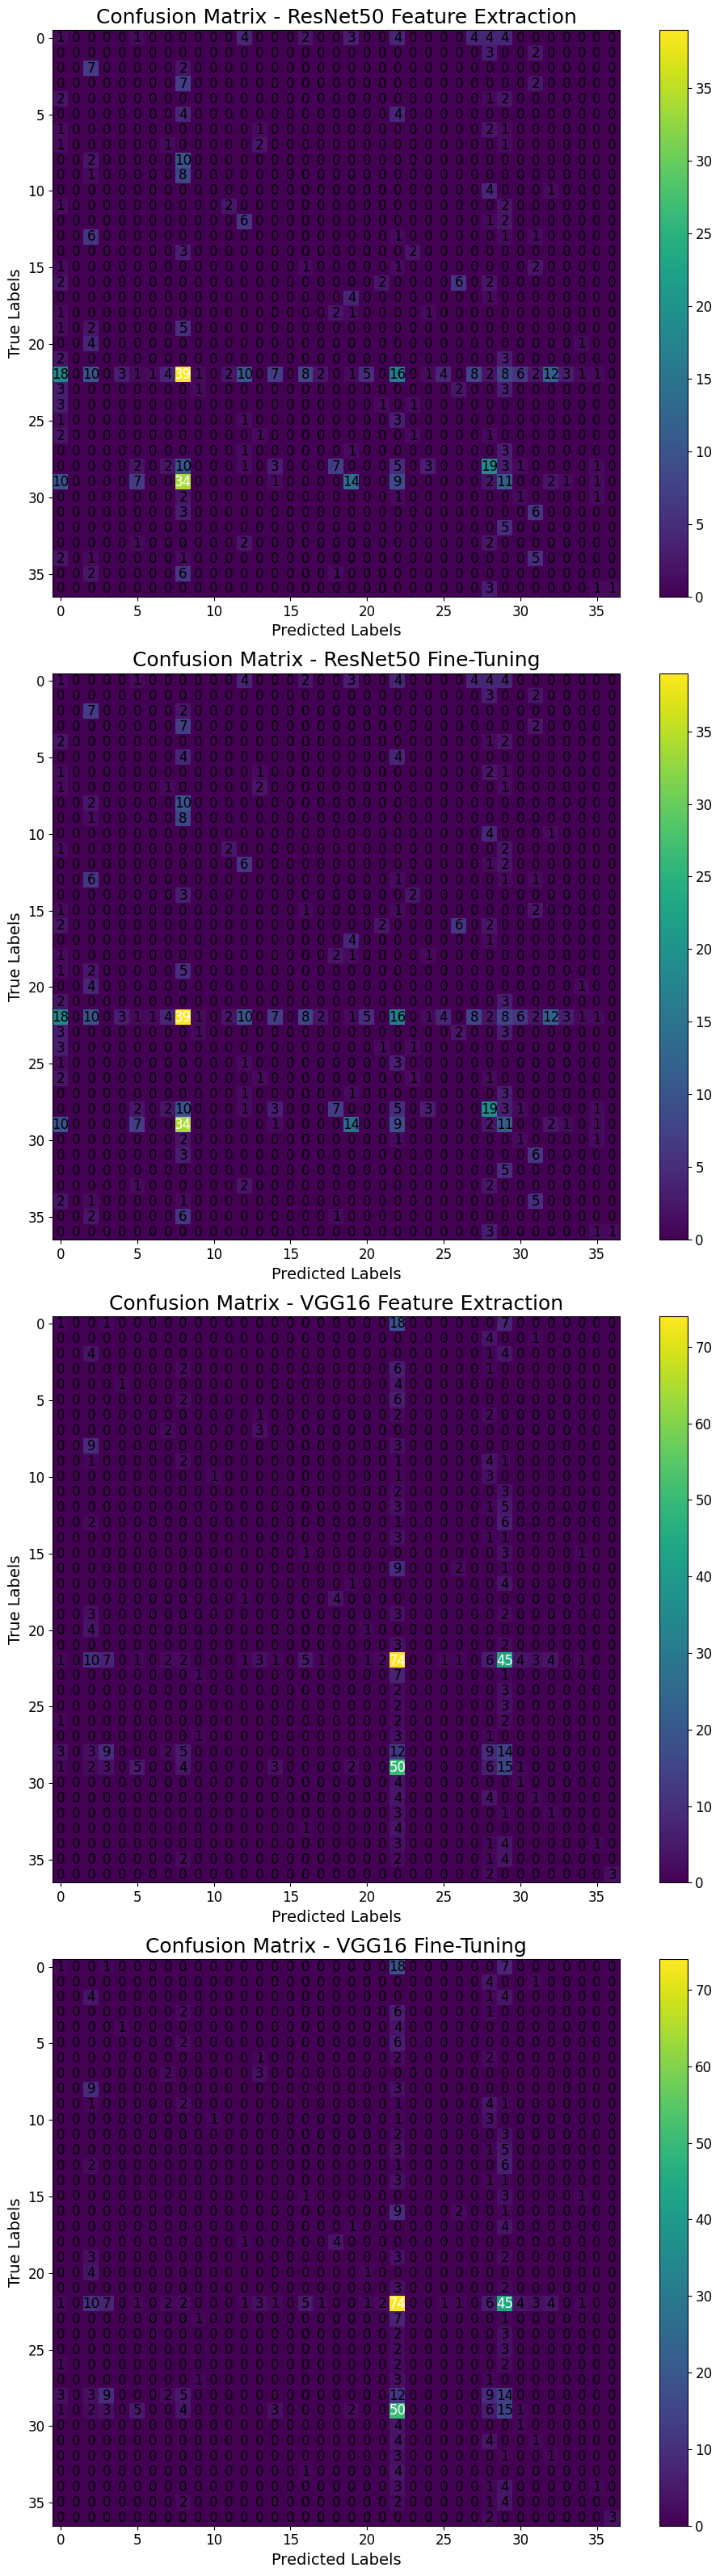

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_model(model, dataloader):
    model.eval()
    predicted_labels = []
    true_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    confusion_mat = confusion_matrix(true_labels, predicted_labels)

    return accuracy, confusion_mat

# Models to evaluate
models = {
    'ResNet50 Feature Extraction': resnet_fe,
    'ResNet50 Fine-Tuning': resnet_ft,
    'VGG16 Feature Extraction': vgg_fe,
    'VGG16 Fine-Tuning': vgg_ft
}

# Calculate accuracy and confusion matrix for each model
results = {}
for model_name, model in models.items():
    accuracy, confusion_mat = evaluate_model(model, test_loader)
    results[model_name] = {
        'accuracy': accuracy,
        'confusion_matrix': confusion_mat
    }

# Plotting the results
fig, axs = plt.subplots(len(results), figsize=(10, 8 * len(results)))

for i, (model_name, result) in enumerate(results.items()):
    ax = axs[i]
    accuracy = result['accuracy']
    confusion_mat = result['confusion_matrix']

    im = ax.imshow(confusion_mat, cmap='viridis')

    ax.set_title(f"Confusion Matrix - {model_name}", fontsize=18)
    ax.set_xlabel("Predicted Labels", fontsize=14)
    ax.set_ylabel("True Labels", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=12)

    # Show values in each cell
    thresh = confusion_mat.max() / 2
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            ax.text(j, i, format(confusion_mat[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if confusion_mat[i, j] > thresh else "black",
                    fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
############## To Do ##############
# Your code ...
###################################